##1.安裝套件

In [111]:
!pip install pandas
!pip install matplotlib
!pip install wordcloud
!pip install jieba

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.colors import Colormap
from wordcloud import WordCloud
import jieba
%matplotlib inline

In [113]:
# Path to the custom font
font_path = 'font/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


##2. 資料前處理

In [114]:
df = pd.read_csv("ptt_ai_221130to240531 (1).csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,ggglu,Finance,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""cow38"", ""cmt...",118.168.142.101,2022-02-16 00:12:45,ptt
1,2,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,[新聞]台銀「三駕馬車」戰略發威前4月,2022-05-21,make1302,Finance,（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威\n，董事長...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""DerLuna"", ""c...",118.171.234.47,2022-05-22 01:11:41,ptt
2,3,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,[新聞]央行徵才月薪最高86K,2023-02-14,kria5304,Finance,https://tinyurl.com/3fcp6ehh\n記者陳美君／台北報導\n2023...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""fill725258"",...",36.224.200.45,2023-02-15 01:06:37,ptt
3,4,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,[新聞]證交所徵才開創數位驅動時代報名至11/17,2023-10-31,BangBang5566,Finance,證交所徵才開創數位驅動時代 報名至11/17止\n\n中央社\n2023年10月30日 週一...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Laviathan"", ...",42.70.143.5,2023-10-31 01:10:55,ptt
4,5,https://www.ptt.cc/bbs/job/M.1641165773.A.E67....,[台中][西屯］飛斯戴爾有限公司/日文客服,2022-01-03,howdigh,job,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,[],125.230.247.67,2022-01-04 00:58:48,ptt


### 2.1 資料清理

In [115]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,【實習】【公司名稱】Influx FinTech 普匯金融科技。【工作職缺】Fintech ...
1,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,[新聞]台銀「三駕馬車」戰略發威前4月,2022-05-21,（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威\n，董事長...,（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威，董事長呂桔...
2,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,[新聞]央行徵才月薪最高86K,2023-02-14,https://tinyurl.com/3fcp6ehh\n記者陳美君／台北報導\n2023...,週二 上午6:32擁抱「金」飯碗的機會來了。中央銀行近日公開徵才，開出的職缺包括「經濟金融...
3,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,[新聞]證交所徵才開創數位驅動時代報名至11/17,2023-10-31,證交所徵才開創數位驅動時代 報名至11/17止\n\n中央社\n2023年10月30日 週一...,證交所徵才開創數位驅動時代 報名至11/17止。中央社2023年10月30日 週一 下午1:...
4,https://www.ptt.cc/bbs/job/M.1641165773.A.E67....,[台中][西屯］飛斯戴爾有限公司/日文客服,2022-01-03,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,job版禁止張貼違反「就業服務法」、「性別平等工作法」、「勞基法」與其他法律之文章發文者已同...
...,...,...,...,...,...
2167,https://www.ptt.cc/bbs/Tech_Job/M.1716963538.A...,[新聞]輝達於高雄設立第二座AI研發中心？經部,2024-05-29,AI大廠輝達（NVIDIA）傳出將於高雄設立全台第二座AI研發中心，引發市場熱議。不過經\n...,AI大廠輝達（NVIDIA）傳出將於高雄設立全台第二座AI研發中心，引發市場熱議。不過經濟部...
2168,https://www.ptt.cc/bbs/Tech_Job/M.1716985339.A...,[新聞]被嗆技術論文沒什麼！楊立昆再槓馬斯克：,2024-05-29,被嗆技術論文沒什麼！楊立昆再槓馬斯克：你特斯拉是靠我 1989 年論文建立的\nhttps:...,被嗆技術論文沒什麼！楊立昆再槓馬斯克：你特斯拉是靠我 1989 年論文建立的 首席AI 科學...
2169,https://www.ptt.cc/bbs/Tech_Job/M.1716986523.A...,[新聞]劉鏡清：看好綠氫不排斥核能,2024-05-29,https://ec.ltn.com.tw/article/paper/1648493\n劉...,不排斥核能。2024/05/29 05:30 其次才是低碳、淨零。〔記者吳欣恬／台北報導〕...
2170,https://www.ptt.cc/bbs/Tech_Job/M.1717126756.A...,[新聞]將量子運算和AI結合在一起的時機愈來愈,2024-05-31,將量子運算和AI結合在一起的時機愈來愈近了\n\n原文網址:\nhttps://bit.ly...,將量子運算和AI結合在一起的時機愈來愈近了。原文網址:


###2.2 文章斷句

In [116]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+|[\d]', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,實習公司名稱Influx FinTech 普匯金融科技
1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,工作職缺Fintech Marketing Intern Fiance Intern徵求條件...
2,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,對國內外金融科技趨勢議題有興趣熟悉 Office 軟體社群軟體
3,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,具圖文影音創作能力者額外加分具 Adobe illustrator Adobe Photo...
4,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,薪資待遇實習元hr連絡方式投遞履歷工作地點台北市中山區松江路號樓之工作時間一週三天可議 午休...
...,...,...,...,...,...
117127,https://www.ptt.cc/bbs/Tech_Job/M.1717128803.A...,[新聞]用矽類比人腦，進度條走到了1/80,2024-05-31,用矽類比人腦，進度條走到了1/80\n夢晨\nhttps://www.qbitai.com/...,神經擬態系統確實不會追求高頻率
117128,https://www.ptt.cc/bbs/Tech_Job/M.1717128803.A...,[新聞]用矽類比人腦，進度條走到了1/80,2024-05-31,用矽類比人腦，進度條走到了1/80\n夢晨\nhttps://www.qbitai.com/...,還開了一個小玩笑
117129,https://www.ptt.cc/bbs/Tech_Job/M.1717128803.A...,[新聞]用矽類比人腦，進度條走到了1/80,2024-05-31,用矽類比人腦，進度條走到了1/80\n夢晨\nhttps://www.qbitai.com/...,人腦就不會以很高的頻率工作
117130,https://www.ptt.cc/bbs/Tech_Job/M.1717128803.A...,[新聞]用矽類比人腦，進度條走到了1/80,2024-05-31,用矽類比人腦，進度條走到了1/80\n夢晨\nhttps://www.qbitai.com/...,不然會發熱冒煙


###2.3 文章斷詞

In [124]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df

ValueError: math domain error

In [120]:
freq_df = pd.DataFrame(pd.value_counts(word_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(10)

,word,count
0,AI,9223
1,公司,3846
2,晶片,3539
3,美元,2769
4,原文,2766
5,技術,2651
6,人工智慧,2387
7,表示,2343
8,工作,2212
9,市場,2110


In [220]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

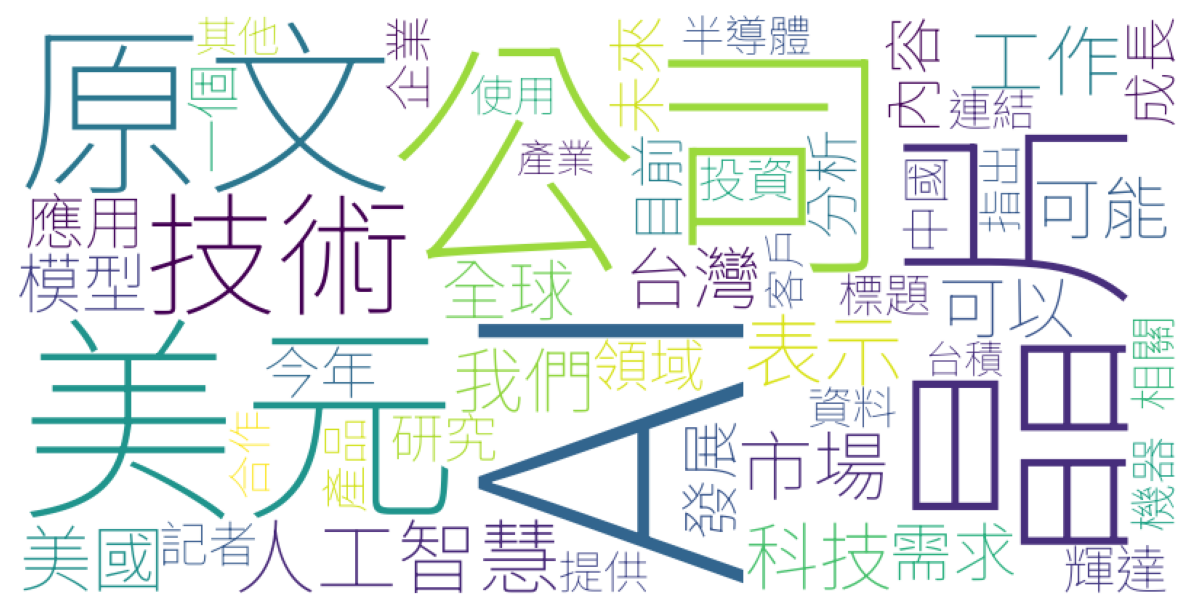

In [221]:
# 繪製文字雲
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400, max_words = 50, font_path = font_path)
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

###2.4 移除停用字

In [126]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()]

In [127]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()]
stopwords_manual = ["原文","表示","我們","可能","可以","目前","使用","今年","記者","內容","一個","指出","標題","連結","其他","公司","評論","台灣","全球","中國"]
stopwords.extend(stopwords_manual)

In [128]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,實習
0,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,名稱
0,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,Influx
0,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,FinTech
0,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,普匯
...,...,...,...,...,...
117129,https://www.ptt.cc/bbs/Tech_Job/M.1717128803.A...,[新聞]用矽類比人腦，進度條走到了1/80,2024-05-31,用矽類比人腦，進度條走到了1/80\n夢晨\nhttps://www.qbitai.com/...,人腦
117129,https://www.ptt.cc/bbs/Tech_Job/M.1717128803.A...,[新聞]用矽類比人腦，進度條走到了1/80,2024-05-31,用矽類比人腦，進度條走到了1/80\n夢晨\nhttps://www.qbitai.com/...,頻率
117129,https://www.ptt.cc/bbs/Tech_Job/M.1717128803.A...,[新聞]用矽類比人腦，進度條走到了1/80,2024-05-31,用矽類比人腦，進度條走到了1/80\n夢晨\nhttps://www.qbitai.com/...,工作
117130,https://www.ptt.cc/bbs/Tech_Job/M.1717128803.A...,[新聞]用矽類比人腦，進度條走到了1/80,2024-05-31,用矽類比人腦，進度條走到了1/80\n夢晨\nhttps://www.qbitai.com/...,發熱


## 3. Lexicon-based 情緒分析

In [131]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})

In [132]:
#將情緒字典與斷詞結果進行合併
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,2022-02-15,[徵才]普匯金融科技-金融科技行銷/金融實習生,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,實習,NaN
1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,2022-02-15,[徵才]普匯金融科技-金融科技行銷/金融實習生,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,名稱,NaN
2,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,2022-02-15,[徵才]普匯金融科技-金融科技行銷/金融實習生,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,Influx,NaN
3,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,2022-02-15,[徵才]普匯金融科技-金融科技行銷/金融實習生,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,FinTech,NaN
4,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,2022-02-15,[徵才]普匯金融科技-金融科技行銷/金融實習生,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,普匯,NaN
...,...,...,...,...,...,...
582221,https://www.ptt.cc/bbs/Tech_Job/M.1717128803.A...,2024-05-31,[新聞]用矽類比人腦，進度條走到了1/80,用矽類比人腦，進度條走到了1/80\n夢晨\nhttps://www.qbitai.com/...,人腦,NaN
582222,https://www.ptt.cc/bbs/Tech_Job/M.1717128803.A...,2024-05-31,[新聞]用矽類比人腦，進度條走到了1/80,用矽類比人腦，進度條走到了1/80\n夢晨\nhttps://www.qbitai.com/...,頻率,NaN
582223,https://www.ptt.cc/bbs/Tech_Job/M.1717128803.A...,2024-05-31,[新聞]用矽類比人腦，進度條走到了1/80,用矽類比人腦，進度條走到了1/80\n夢晨\nhttps://www.qbitai.com/...,工作,NaN
582224,https://www.ptt.cc/bbs/Tech_Job/M.1717128803.A...,2024-05-31,[新聞]用矽類比人腦，進度條走到了1/80,用矽類比人腦，進度條走到了1/80\n夢晨\nhttps://www.qbitai.com/...,發熱,NaN


### 3.1 正負向情緒詞彙頻率折線圖圖

In [133]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative")
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
2,2022-01-03,negative,2
3,2022-01-03,positive,6
5,2022-01-04,negative,6
6,2022-01-04,positive,46
10,2022-01-05,negative,7
...,...,...,...
3326,2024-05-29,positive,29
3330,2024-05-30,negative,11
3331,2024-05-30,positive,54
3336,2024-05-31,negative,19


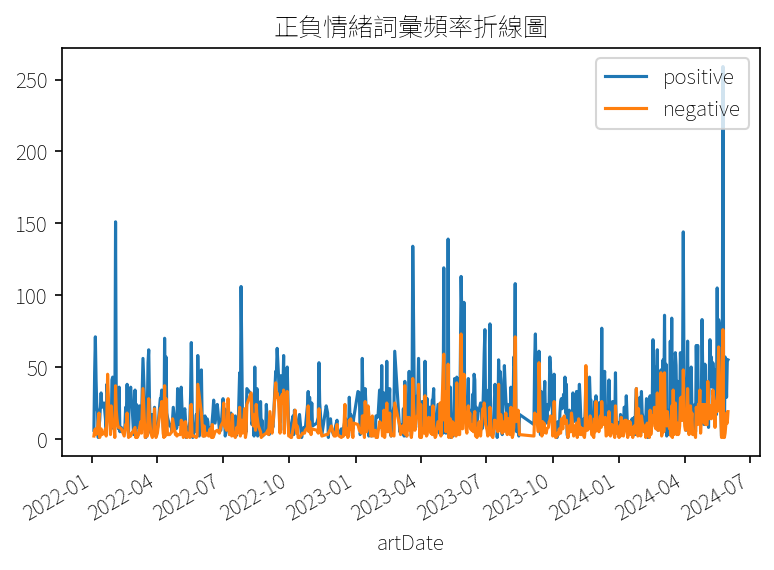

In [134]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖")  # 記得加上才能顯示中文
plt.show()

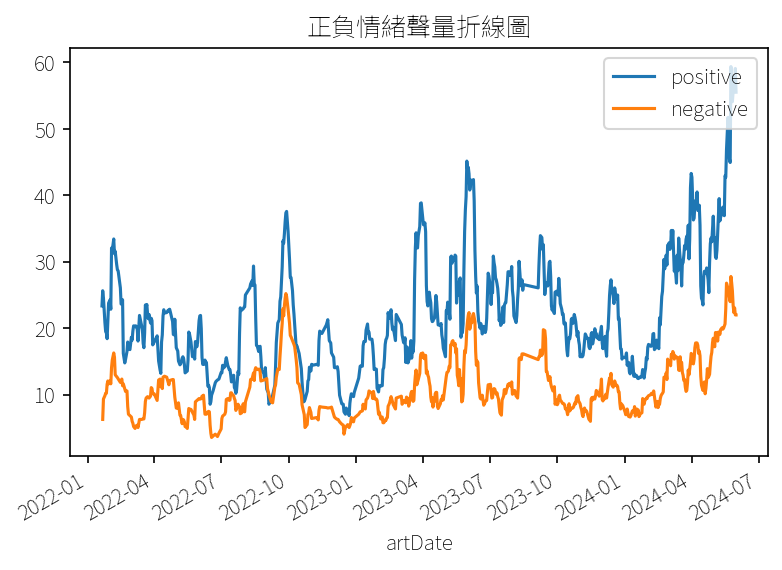

In [135]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖")  # 記得加上才能顯示中文
plt.show()

畫出每天的情緒總分數，可以看到正面的詞出現頻率幾乎每天都超過負面，關於AI的討論大多是正向的。

## 3.2 正負向情緒詞彙比例折線圖圖

In [136]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)

pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

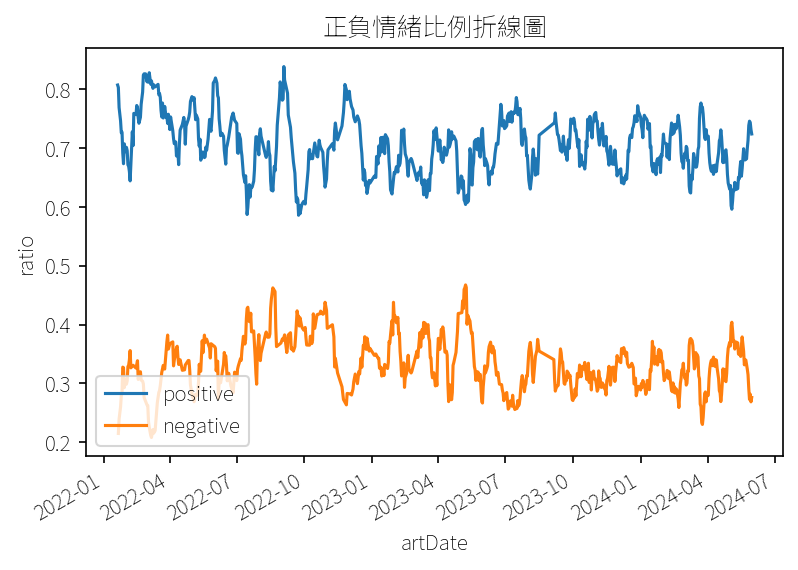

In [137]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖")

### 3.3 正負向情緒分數折線圖

In [138]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

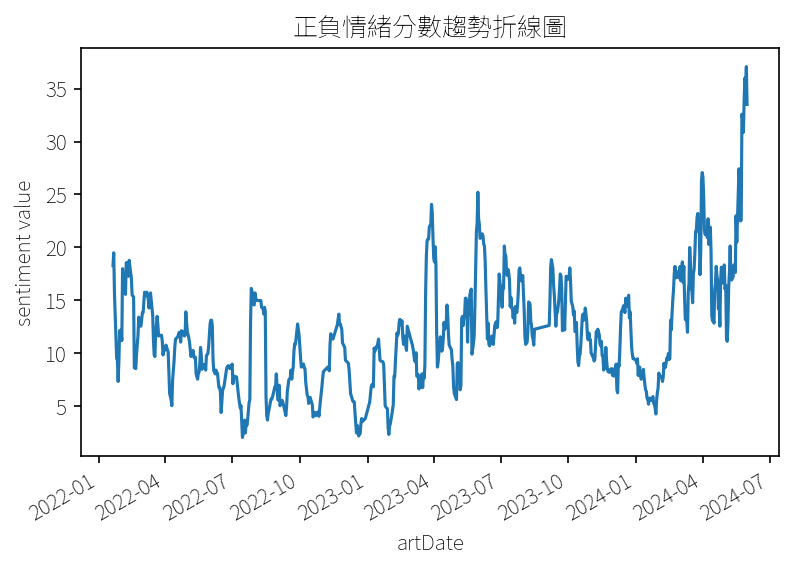

In [139]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖")

### 3.4 文章為單位的情緒分析

In [140]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})


ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)

ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,5,0,0,0,5,0,5,正向
1,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,8,0,0,2,6,0,4,正向
2,https://www.ptt.cc/bbs/Finance/M.1676346325.A....,3,0,0,0,3,0,3,正向
3,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,9,0,0,0,9,0,9,正向
4,https://www.ptt.cc/bbs/Option/M.1694940597.A.6...,10,0,2,5,4,1,-1,負向
...,...,...,...,...,...,...,...,...,...
2033,https://www.ptt.cc/bbs/part-time/M.1683302322....,12,2,1,4,7,0,3,正向
2034,https://www.ptt.cc/bbs/part-time/M.1693977838....,9,1,1,5,4,0,-1,負向
2035,https://www.ptt.cc/bbs/part-time/M.1697798178....,14,0,0,3,11,0,8,正向
2036,https://www.ptt.cc/bbs/part-time/M.1698920789....,16,0,0,3,13,0,10,正向


In [141]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date

sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])

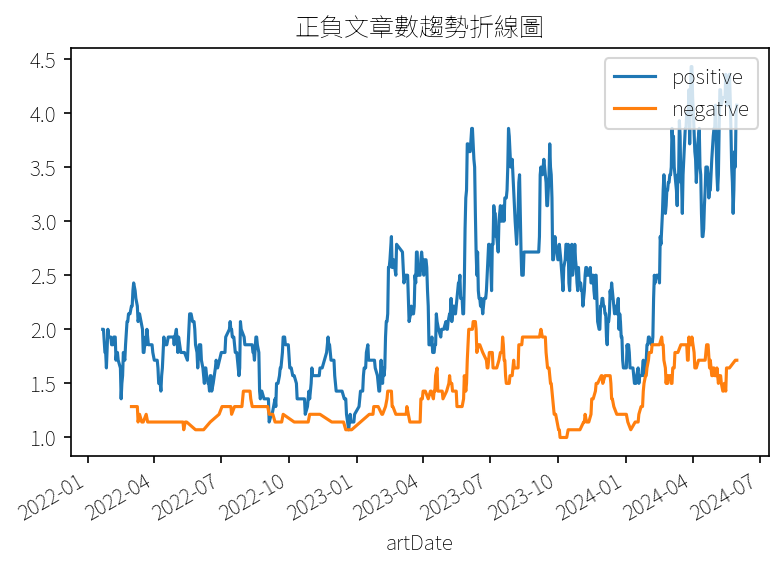

In [142]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖")  # 記得加上才能顯示中文
plt.show()

### 3.5 情緒代表字

In [144]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

<ipython-input-145-84c14012022f>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
<ipython-input-145-84c14012022f>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

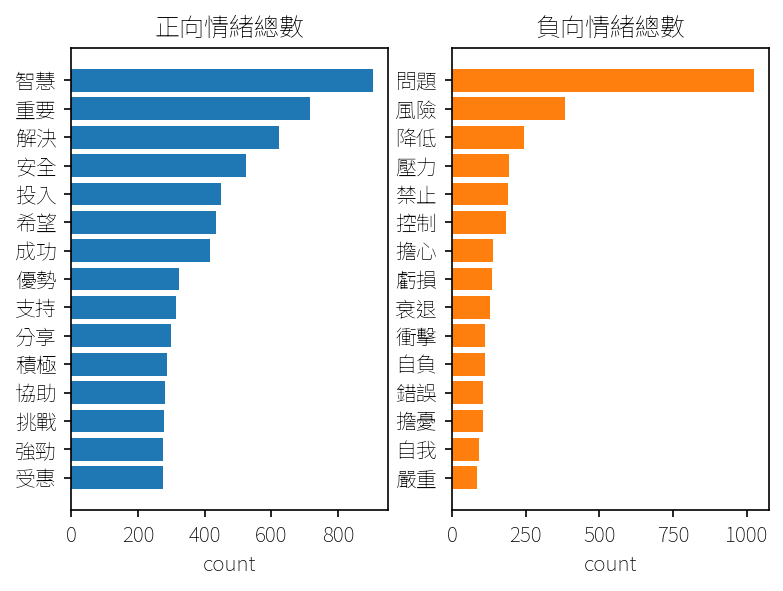

In [145]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

In [222]:
# 設定要移除的字詞列表
words_to_remove = ["問題","智慧","投入","協助","挑戰","強勁","問題","降低","壓力","禁止","控制","自我","重要","遊戲","創造","解決","AI"]
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict_revise,
                              how="left")

<ipython-input-223-31dcf72d5d93>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
<ipython-input-223-31dcf72d5d93>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

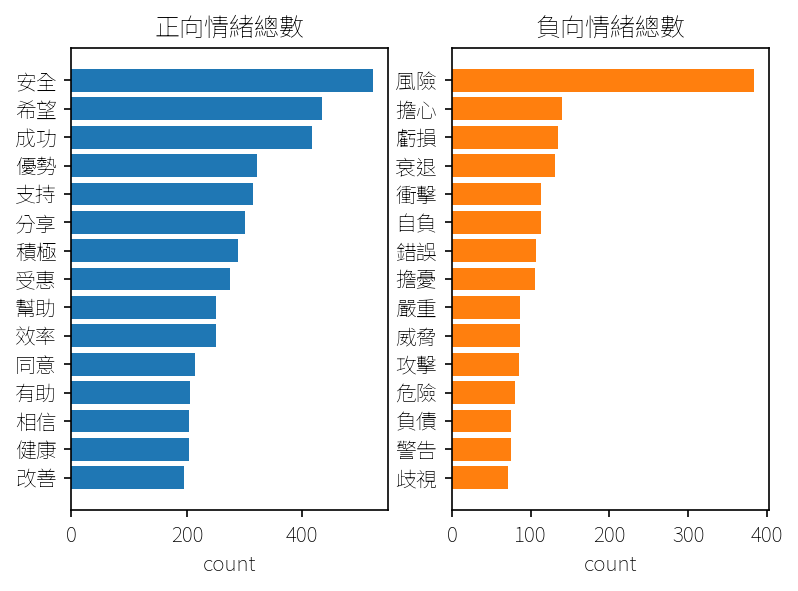

In [223]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

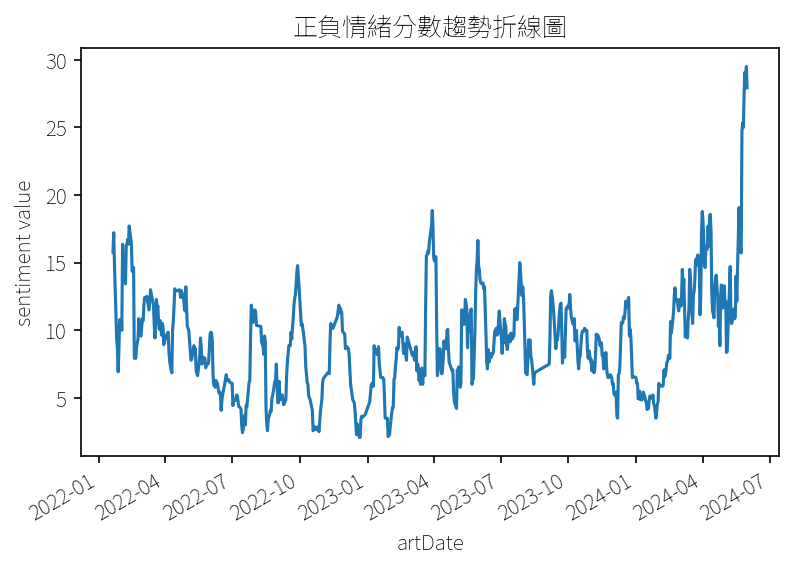

In [224]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative")
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖")

### 3.6 文字雲

In [225]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")

sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")

In [266]:
date = "2023-04-01"
end_date = "2023-06-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

,word,size
3,AI,259
3758,虧損,126
4568,風險,93
1300,同比,92
3560,美元,89
...,...,...
1882,師都,1
1883,師長,1
1885,師預計,1
1888,帶領,1


(-0.5, 399.5, 199.5, -0.5)

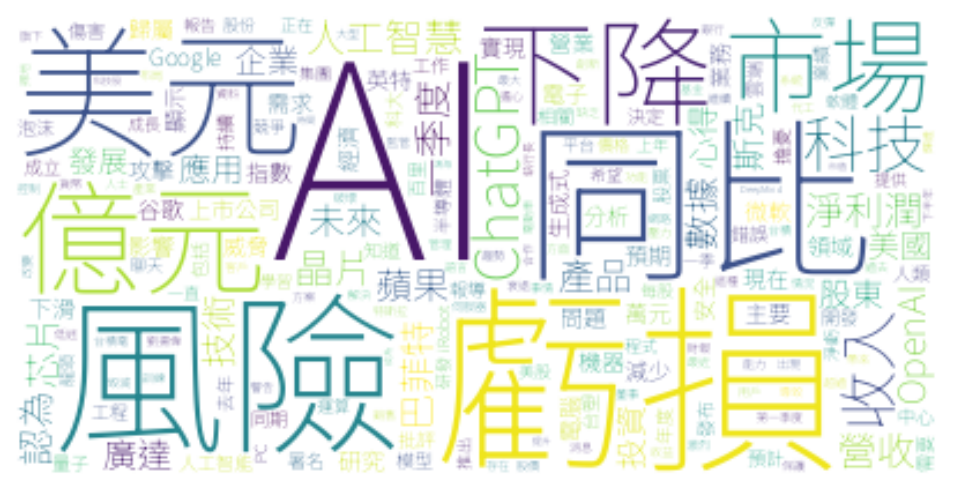

In [267]:
# wordcloud 的 input 是 dictionary
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

(-0.5, 399.5, 199.5, -0.5)

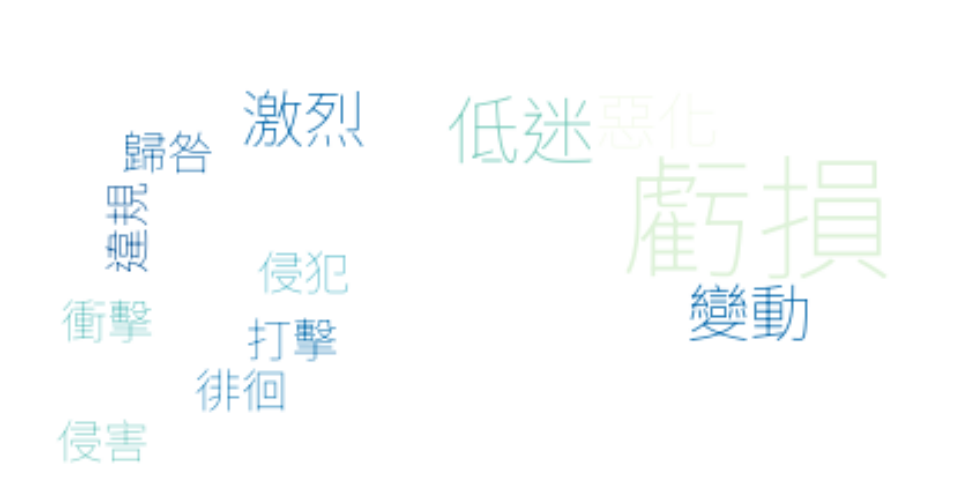

In [261]:
date = "2023-04-01"
end_date = "2023-06-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('虧損')) & ( # 內文包含虧損
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud,
    interpolation="bilinear"
)
plt.axis("off")

In [263]:
date = "2023-04-01"
end_date = "2023-06-01"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('虧損'))

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
32179,https://www.ptt.cc/bbs/Stock/M.1682555876.A.E3...,[新聞]Meta營收超預期祖克柏說AI帶財,2023-04-27,原文標題：\n\nMeta營收超預期 祖克柏說AI帶財 盤後股價狂噴12%\n\n原文連結：...,盤後漲,正向
32180,https://www.ptt.cc/bbs/Stock/M.1682555876.A.E3...,[新聞]Meta營收超預期祖克柏說AI帶財,2023-04-27,原文標題：\n\nMeta營收超預期 祖克柏說AI帶財 盤後股價狂噴12%\n\n原文連結：...,祖克柏說AI帶財,正向
32181,https://www.ptt.cc/bbs/Stock/M.1682555876.A.E3...,[新聞]Meta營收超預期祖克柏說AI帶財,2023-04-27,原文標題：\n\nMeta營收超預期 祖克柏說AI帶財 盤後股價狂噴12%\n\n原文連結：...,有先問過AI總司令嘎偉老蘇嗎,正向
32182,https://www.ptt.cc/bbs/Stock/M.1682555876.A.E3...,[新聞]Meta營收超預期祖克柏說AI帶財,2023-04-27,原文標題：\n\nMeta營收超預期 祖克柏說AI帶財 盤後股價狂噴12%\n\n原文連結：...,這兩天微軟和臉書財報發佈後都噴出,正向
32183,https://www.ptt.cc/bbs/Stock/M.1682555876.A.E3...,[新聞]Meta營收超預期祖克柏說AI帶財,2023-04-27,原文標題：\n\nMeta營收超預期 祖克柏說AI帶財 盤後股價狂噴12%\n\n原文連結：...,晚上還有亞馬遜要公佈,正向
...,...,...,...,...,...,...
89817,https://www.ptt.cc/bbs/Tech_Job/M.1683130456.A...,[新聞]郭台銘再開支票！若當選將改革台電開放,2023-05-04,https://tw.nextapple.com/finance/20230503/8295...,開放科技業與國外公司簽訂供電合約,正向
89818,https://www.ptt.cc/bbs/Tech_Job/M.1683130456.A...,[新聞]郭台銘再開支票！若當選將改革台電開放,2023-05-04,https://tw.nextapple.com/finance/20230503/8295...,工商建設研究會今天邀請鴻海創辦人爭取國民黨總統參選人提名的郭台銘演講用科技和世界做朋友,正向
89819,https://www.ptt.cc/bbs/Tech_Job/M.1683130456.A...,[新聞]郭台銘再開支票！若當選將改革台電開放,2023-05-04,https://tw.nextapple.com/finance/20230503/8295...,郭台銘演講前先澄清日前對於核能政策的發言,正向
89820,https://www.ptt.cc/bbs/Tech_Job/M.1683130456.A...,[新聞]郭台銘再開支票！若當選將改革台電開放,2023-05-04,https://tw.nextapple.com/finance/20230503/8295...,他怪自己沒有說清楚,正向


篩選出"虧損"相關的負面內容，查到許多晶片大廠(如：Intel、海力士、寒武紀)2023年第一季度出現虧損的現象。

(-0.5, 399.5, 199.5, -0.5)

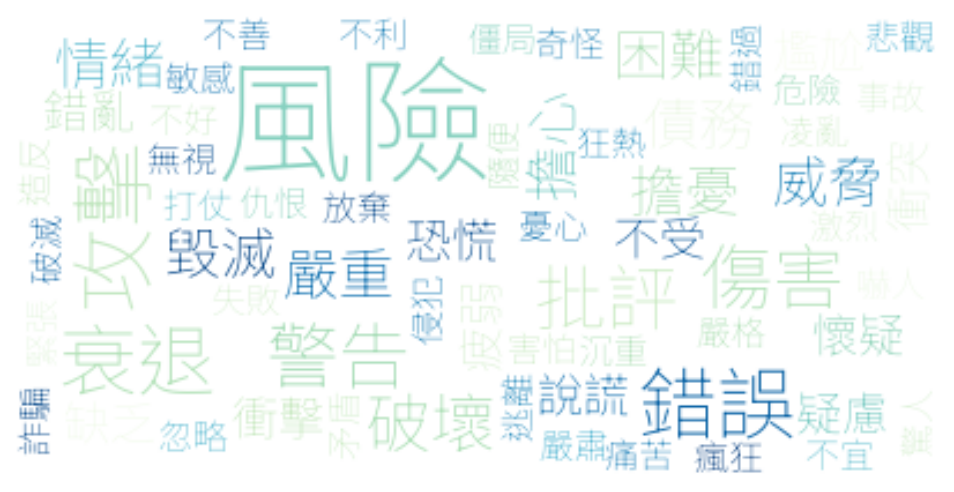

In [260]:
date = "2023-04-01"
end_date = "2023-06-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('風險')) & ( # 內文包含虧損
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud,
    interpolation="bilinear"
)
plt.axis("off")

In [259]:
date = "2023-04-01"
end_date = "2023-06-01"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('風險'))

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
30519,https://www.ptt.cc/bbs/Stock/M.1680310939.A.77...,[新聞]Google和DeepMind擱置恩怨合作攻OpenAI,2023-04-01,原文標題：\n媒體：Google和DeepMind擱置多年恩怨 聯手合作以追趕OpenAI\...,原來年Google成立Google Health瓢竊Deepmind程式碼導致Deepmin...,負向
30520,https://www.ptt.cc/bbs/Stock/M.1680310939.A.77...,[新聞]Google和DeepMind擱置恩怨合作攻OpenAI,2023-04-01,原文標題：\n媒體：Google和DeepMind擱置多年恩怨 聯手合作以追趕OpenAI\...,導致之後數次要求分家,負向
30521,https://www.ptt.cc/bbs/Stock/M.1680310939.A.77...,[新聞]Google和DeepMind擱置恩怨合作攻OpenAI,2023-04-01,原文標題：\n媒體：Google和DeepMind擱置多年恩怨 聯手合作以追趕OpenAI\...,現在OpenAI的出現導致Google必須放軟跟Deepmind協商Google的Bard看...,負向
30522,https://www.ptt.cc/bbs/Stock/M.1680310939.A.77...,[新聞]Google和DeepMind擱置恩怨合作攻OpenAI,2023-04-01,原文標題：\n媒體：Google和DeepMind擱置多年恩怨 聯手合作以追趕OpenAI\...,還不得使用ChatGPT的數據現在有Deepmind的幫忙,負向
30523,https://www.ptt.cc/bbs/Stock/M.1680310939.A.77...,[新聞]Google和DeepMind擱置恩怨合作攻OpenAI,2023-04-01,原文標題：\n媒體：Google和DeepMind擱置多年恩怨 聯手合作以追趕OpenAI\...,相信以Deepmind的能力應該會有飛躍的進步,負向
...,...,...,...,...,...,...
91986,https://www.ptt.cc/bbs/Tech_Job/M.1685638701.A...,[新聞]輝達曝密友廣達、美超微、鴻佰黃仁勳解,2023-06-02,https://money.udn.com/money/story/5612/7202043...,黃仁勳解釋一身黑原因,正向
91987,https://www.ptt.cc/bbs/Tech_Job/M.1685638701.A...,[新聞]輝達曝密友廣達、美超微、鴻佰黃仁勳解,2023-06-02,https://money.udn.com/money/story/5612/7202043...,現在是台灣的黃金時刻,正向
91988,https://www.ptt.cc/bbs/Tech_Job/M.1685638701.A...,[新聞]輝達曝密友廣達、美超微、鴻佰黃仁勳解,2023-06-02,https://money.udn.com/money/story/5612/7202043...,輝達創辦人黃仁勳旋風式橫掃COMPUTEX,正向
91989,https://www.ptt.cc/bbs/Tech_Job/M.1685638701.A...,[新聞]輝達曝密友廣達、美超微、鴻佰黃仁勳解,2023-06-02,https://money.udn.com/money/story/5612/7202043...,生成式AI及背後的龐大生態系正由他帶領的供應鏈夥伴獨領風騷,正向


篩選出與"風險"相關的負面內容，發現其中AI所造成的風險包含隱私(如：義大利封鎖ChatGPT)以及股市泡沫化(如：AI熱潮推動相關概念股飆漲)